# Deciphering Stocks : Time series Analysis and Risk Metrics

1. Stock data retrieval and plotting
2. Correlation between the stocks
3. Portfolio Optimization - Minimum Variance Portfolio
4. VaR and ES - Historical
5. VaR and ES - Gaussian
6. Time series Analysis
  - FB Prophet
  - Random Forest
  - LSTM

# Stock data retrieval and plotting

In [ ]:
!pip install alpha_vantage

In [ ]:
# Getting stock data for TSLA, JNJ, KO
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

api_key = 'YVMGNFOENSJ6394X'
ts = TimeSeries(key=api_key, output_format='pandas')

symbols = ['TSLA', 'JNJ', 'KO']

data = {}
for symbol in symbols:
    data[symbol], _ = ts.get_daily(symbol=symbol, outputsize='full')

In [ ]:
# Consider data only from when TSLA is not NaN
tesla_dates = data['TSLA'].index

filtered_data = {}
for symbol in symbols:
    filtered_data[symbol] = data[symbol].loc[tesla_dates]
print(filtered_data)

{'TSLA':             1. open   2. high    3. low  4. close    5. volume
date                                                          
2024-04-16  156.742  158.1900  153.7500    157.11   96999956.0
2024-04-15  170.240  170.6900  161.3800    161.48  100245310.0
2024-04-12  172.340  173.8099  170.3644    171.05   64722669.0
2024-04-11  172.550  175.8800  168.5100    174.60   94515987.0
2024-04-10  173.040  174.9300  170.0100    171.76   84532407.0
...             ...       ...       ...       ...          ...
2010-07-06   20.000   20.0000   15.8300     16.11    6866900.0
2010-07-02   23.000   23.1000   18.7100     19.20    5139800.0
2010-07-01   25.000   25.9200   20.2700     21.96    8218800.0
2010-06-30   25.790   30.4192   23.3000     23.83   17187100.0
2010-06-29   19.000   25.0000   17.5400     23.89   18766300.0

[3473 rows x 5 columns], 'JNJ':             1. open  2. high   3. low  4. close   5. volume
date                                                       
2024-04-16   145.01

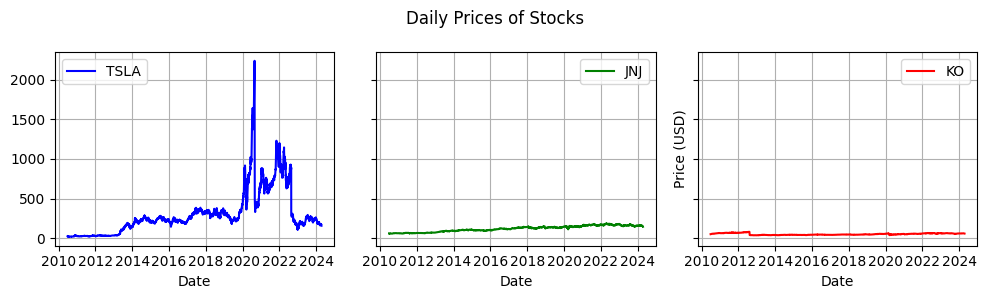

In [ ]:
# Plot the data
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
colors = ['blue', 'green', 'red']

for i, symbol in enumerate(symbols):
    axs[i].plot(filtered_data[symbol].index, filtered_data[symbol]['4. close'], color=colors[i], label=symbol)
    axs[i].set_xlabel('Date')
    axs[i].grid(True)
    axs[i].legend()
plt.ylabel('Price (USD)')
plt.suptitle('Daily Prices of Stocks')
plt.tight_layout()
plt.show()

# Correlation between the stocks

In [ ]:
# Calculate the returns
returns = {}
for symbol in symbols:
    filtered_data[symbol]['Return'] = filtered_data[symbol]['4. close'].pct_change()
    returns[symbol] = filtered_data[symbol]['Return']

returns_df = pd.DataFrame(returns)

In [ ]:
# Calculate correlation matrix
correlation_matrix = returns_df.corr()

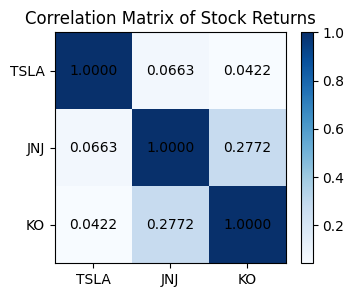

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the correlation matrix
plt.figure(figsize=(4, 3))
plt.imshow(correlation_matrix, cmap='Blues', interpolation='nearest')

for i in range(len(symbols)):
    for j in range(len(symbols)):
        plt.text(j, i, '{:.4f}'.format(correlation_matrix.values[i, j]), horizontalalignment='center', verticalalignment='center')

plt.colorbar()
plt.title('Correlation Matrix of Stock Returns')
plt.xticks(range(len(symbols)), symbols)
plt.yticks(range(len(symbols)), symbols)
plt.show()

# Portfolio Optimization - Minimum Variance Portfolio

In [ ]:
# Find weights for minimum variance portfolio
import numpy as np

covariance_matrix = returns_df.cov()
expected_returns = returns_df.mean()
e = np.array([1,1,1])

weights = (np.linalg.inv(covariance_matrix) @ e)/(np.transpose(e) @ np.linalg.inv(covariance_matrix) @ e)

for symbol, weight in zip(symbols, weights):
    print(f"Weight for {symbol}: {weight}")

Weight for TSLA: 0.008727209043414036
Weight for JNJ: 0.8593503876701679
Weight for KO: 0.13192240328641805


In [ ]:
# Find expected return of portfolio

portfolio_returns = returns_df.dot(weights.reshape(-1,1))
expected_returns_portfolio = np.mean(portfolio_returns)
print("Expected return of portfolio: ",expected_returns_portfolio)

Expected return of portfolio:  -0.0001496869034174549


# Historical Methods

In [ ]:
# Computing losses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

losses = -portfolio_returns
losses = losses.dropna()

In [ ]:
# Find the VaR and ES using ordered statistic approach
sorted_losses = np.sort(losses.values, axis=0)
confidence_level = 0.99

var_index = len(sorted_losses)-int(np.floor((1 - confidence_level) * len(sorted_losses)))
var_ordered_statistic = sorted_losses[var_index]

exceedances = sorted_losses[var_index:]
es_ordered_statistic = np.mean(exceedances)

print(f"VaR at {confidence_level * 100}% confidence level: {var_ordered_statistic}")
print(f"Expected Shortfall at {confidence_level * 100}% confidence level: {es_ordered_statistic}")

VaR at 99.0% confidence level: [0.02447366]
Expected Shortfall at 99.0% confidence level: 0.03837255274489254


# Gaussian VaR and ES: Covariance Model

In [ ]:
from scipy.stats import norm
import math
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

phi_inverse = norm.ppf(confidence_level)

var_gaussian = phi_inverse*(math.sqrt(np.var(losses)))
es_gaussian = (np.exp(-0.5 * phi_inverse**2) / (np.sqrt(2 * np.pi)*(1-confidence_level)))*(math.sqrt(np.var(losses)))

print(f"VaR at {confidence_level * 100}% confidence level: {var_gaussian}")
print(f"Expected Shortfall at {confidence_level * 100}% confidence level: {es_gaussian}")

VaR at 99.0% confidence level: 0.023969085891080433
Expected Shortfall at 99.0% confidence level: 0.027460531281004827


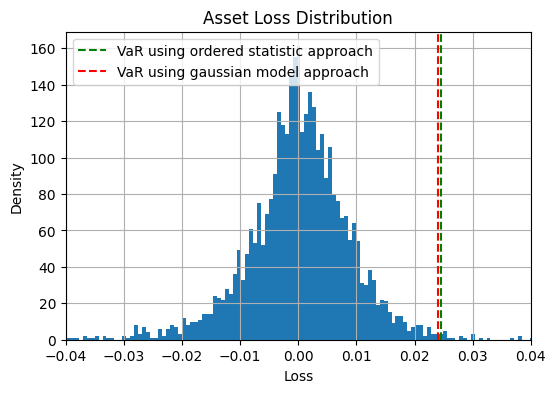

In [ ]:
# Plotting
plt.figure(figsize=(6,4))
plt.hist(losses,bins=300)

plt.axvline(x=var_ordered_statistic, color='g', linestyle='--', label=f'VaR using ordered statistic approach')
plt.axvline(x=var_gaussian, color='r', linestyle='--', label=f'VaR using gaussian model approach')

plt.title('Asset Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.xlim(-0.04, 0.04)
plt.grid(True)
plt.legend()
plt.show()

# Timeseries forecasting
- FB Prophet
- LSTM

In [ ]:
!python -m pip install prophet

In [ ]:
# Prepare Portfolio data
import pandas as pd
from prophet import Prophet

portfolio_returns=portfolio_returns.dropna()
portfolio_returns['ds'] = portfolio_returns.index
portfolio_returns.rename(columns={0:'y'}, inplace=True)

tsla_df = portfolio_returns[['ds', 'y']]

In [ ]:
# Create and fit Prophet model
model = Prophet()
model.fit(tsla_df)

future = model.make_future_dataframe(periods=90)
future = future.tail(90)

forecast = model.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmput7pq5sg/j8p23cz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmput7pq5sg/zxxcem5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62440', 'data', 'file=/tmp/tmput7pq5sg/j8p23cz4.json', 'init=/tmp/tmput7pq5sg/zxxcem5i.json', 'output', 'file=/tmp/tmput7pq5sg/prophet_model0kx_qm2y/prophet_model-20240417030558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

actual_values = tsla_df['y'].values[-90:]

predicted_values = forecast['yhat'].values[-len(actual_values):]
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.007698034301263845


In [ ]:
!pip install tensorflow

In [ ]:
# Prepare data for LSTM
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_df['y'].values.reshape(-1, 1))

def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_dataset(scaled_data, time_steps)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
# Split into test-train sets
test_days = 90
split = len(X) - test_days
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/200
106/106 [==============================] - 3s 29ms/step - loss: 0.0026
Epoch 2/200
106/106 [==============================] - 3s 28ms/step - loss: 0.0026
Epoch 3/200
106/106 [==============================] - 2s 17ms/step - loss: 0.0026
Epoch 4/200
106/106 [==============================] - 2s 18ms/step - loss: 0.0026
Epoch 5/200
106/106 [==============================] - 2s 18ms/step - loss: 0.0026
Epoch 6/200
106/106 [==============================] - 2s 18ms/step - loss: 0.0026
Epoch 7/200
106/106 [==============================] - 2s 18ms/step - loss: 0.0026
Epoch 8/200
106/106 [==============================] - 3s 29ms/step - loss: 0.0026
Epoch 9/200
106/106 [==============================] - 2s 18ms/step - loss: 0.0026
Epoch 10/200
106/106 [==============================] - 2s 18ms/step - loss: 0.0026
Epoch 11/200
106/106 [==============================] - 2s 18ms/step - loss: 0.0026
Epoch 12/200
106/106 [==============================] - 2s 18ms/step - loss: 0.0026
E

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(tsla_df['y'].values[-len(predictions):], predictions))
print("RMSE:", rmse)

RMSE: 0.007385964938768664
